In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [15]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo
from MapMatching import MapMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import copy
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass
    
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())
            
class NuscenesSimulation():
    def __init__(self, model, scene_id=5, **kwargs):
        self.model = model
        directory = kwargs.pop('directory', r"/home/kfir/workspace/nuScenes/v1.0-trainval")
        self.mm = kwargs.pop('mm', False)
        self.nmax = kwargs.pop('Nmax', 800)
        self.dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id)
        self.video = NuscenesVideo(history=True, scene=scene)
        self.video_debug = NuscenesVideoDebug(history=True, scene=scene)
        self.pf_video = PFVideo(history=True, scene=scene, N=self.nmax)
        self.map_matching = MapMatching(N=200)
        self.lane = None
        self.scene = scene
        
    def getBestLane(self, prior):
        if self.lane is None:
                self.lane = prior[0]
                lane = prior[0]
        else:
            for pr in prior:
                if 1:#if np.linalg.norm(self.lane["poly"][1]-pr["poly"][1]) < 2 and np.linalg.norm(self.lane["poly"][0]-pr["poly"][0]) < 0.1:
                    lane = pr
                    self.lane = pr

        lanes = [lane]
        return lanes
    
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
        
    def run(self,start, N, generate_video=False, video_with_priors=False, debug=False, translate=True):
        start_idx = start
        first = True
        for t in range(start_idx,start_idx + N):
            print(f"frame {t}")
            zw, covw, prior, video_data, nusc_map = self.dataset.getData(t)
            if first:
                translation = np.array(video_data["pos"][0:2])
                print("translation", translation)
                first = False
                
            #lanes = self.getBestLane(prior)
            lanes = copy.deepcopy(prior)
            if translate:
                lanes = self.translatePrior(translation, lanes)
                zw = self.translateMeasurements(zw, translation)
            prior_list = []
            for lane in lanes:
                (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
                prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
    
            points, polynoms = self.model.run(zw,covw,prior_list)
            if translate:
                points, polynoms = self.translateOutput(points, polynoms, -1*translation)
                
            #Run map-matching!
            if self.mm:
                extended_tracks = self.model.getExtendedTracks()
                orig_world_ref = video_data["pos_imu"]
                world_ref = np.array([orig_world_ref[0]-translation[0], orig_world_ref[1]-translation[1]]) 
                self.map_matching.run(extended_tracks, nusc_map, orig_world_ref, world_ref, video_data["rot"], video_data["heading"], video_data["odometry"])
            
            try:
                self.video.save(t,video_data, polynoms, nusc_map, video_with_priors=video_with_priors)
            except:
                pass
            try:
                self.video_debug.save(t,video_data, polynoms,points, nusc_map,self.model.getDebugInfo(), video_with_priors=video_with_priors)
            except:
                pass

            if self.mm:
                mm_results = self.map_matching.getResults()
                mm_results["pf_best_pos"] += translation[0:2]
                mm_results["pf_mean_pos"] += translation[0:2]
                print("mm_results[pf_mean_pos]", mm_results["pf_mean_pos"], "IMU pos", video_data["pos_imu"], "GT", video_data["pos"])
                self.pf_video.save(t,video_data, mm_results, polynoms, nusc_map)
        
        if generate_video:
            try:
                self.video.generate(name=f"video\scene{self.scene}.avi", fps=5)
            except:
                pass
            try:
                self.video_debug.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
            try:
                self.pf_video.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass

scene_id=426 scene_name=scene-0536 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:273: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


frame 90
ridx 782 rot_imu.shape (15707, 2)
translation [309.1440058 668.7799789]
Number of point tracks before run() 0
Number of extended tracks before run() 0
xlim [84.08856972896103, 297.3980688730894] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0


mm_results[pf_mean_pos] [309.1376382  668.78624088] IMU pos [309.1439659  668.77989518   0.        ] GT [309.1440057979007, 668.7799788974357, 0.0]
frame 91
ridx 790 rot_imu.shape (15707, 2)
Number of point tracks before run() 55
Number of extended tracks before run() 0
xlim [84.08856972896103, 297.3980688730894] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [309.13253927 668.78476243] IMU pos [309.1439659  668.77989518   0.        ] GT [309.14402876530903, 668.7799674290491, 0.0]
frame 92
ridx 797 rot_imu.shape (15707, 2)
Number of point tracks before run() 61
Number of extended tracks before run() 0
xlim [84.08856972896103, 297.4911218334663] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [309.15538541 668.77285616] IMU pos [309.1439659  668.77989518   0.        ] GT [309.1440480872666, 668.779957642414, 0.0]
frame 93
ridx 811 rot_imu.shape (15707, 2)
Number of point tracks before run() 67
Number of extended tra

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 304.320017406457] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [309.11774559 668.79749689] IMU pos [309.10943907 668.79788278   0.        ] GT [309.1018039883952, 668.8019204648524, 0.0]
frame 98
ridx 849 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 304.320017406457] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [309.01933414 668.83336244] IMU pos [309.07015979 668.81843079   0.        ] GT [309.0685879630405, 668.8192348436446, 0.0]
frame 99
ridx 862 rot_imu.shape (15707, 2)
Number of point tracks before run() 130
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 304.74842390952233] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [308.91889648 668.87409371] IMU pos [309.00138575 668.85457498   0.        ] GT [308.9782307477867, 668.8662813159683, 0.0]
frame 100
ridx 870 rot_imu.shape (15707, 2)
Number of point tracks before run() 141
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 304.74842390952233] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
m

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [308.7497328  668.95643078] IMU pos [308.8026677  668.95970293   0.        ] GT [308.76374007977665, 668.9798752398133, 0.0]
frame 103
ridx 891 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [308.67933225 668.99813385] IMU pos [308.73324665 668.99662863   0.        ] GT [308.6805542437214, 669.0244546621221, 0.0]
frame 104
ridx 900 rot_imu.shape (15707, 2)
Number of point tracks before run() 170
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
created an extended object! [-1.88831168e+01 -8.59043778e-01 -7.21056694e-03 -4.12532673e+01
 -3.02212886e+01] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [308.50109058 669.05907734] IMU pos [308.63532638 669.04888096   0.        ] GT [308.58566992008673, 669.0754876632853, 0.0]
frame 105
ridx 914 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [308.267057   669.19558294] IMU pos [308.4294743  669.15935696   0.        ] GT [308.379828285641, 669.1872607007188, 0.0]
frame 106
ridx 921 rot_imu.shape (15707, 2)
Number of point tracks before run() 162
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [308.14288785 669.2659223 ] IMU pos [308.31256538 669.2223271    0.        ] GT [308.25528287182533, 669.2552805475261, 0.0]
frame 107
ridx 929 rot_imu.shape (15707, 2)
Number of point tracks before run() 167
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =

xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [306.5453947  670.10334357] IMU pos [306.73670578 670.08570984   0.        ] GT [306.340696352368, 670.3158105920077, 0.0]
frame 117
ridx 1017 rot_imu.shape (15707, 2)
Number of point tracks before run() 166
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [306.22180325 670.29076692] IMU pos [306.37525103 670.29018358   0.        ] GT [305.9222892581488, 6

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [305.66630524 670.61823403] IMU pos [305.79459103 670.62779844   0.        ] GT [305.30601447678464, 670.9142324867643, 0.0]
frame 121
ridx 1046 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.15059283e+00 -7.23580871e-01 -3.53243039e-03 -6.04366186e+01
 -4.86140187e+01] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [305.39832604 670.78709063] IMU pos [305.59277353 670.75000822   0.        ] GT [305.0814638924576, 671.0502076884007, 0.0]
frame 122
ridx 1052 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [305.17183633 670.92945389] IMU pos [305.39543635 670.87229188   0.        ] GT [304.8651723048556, 671.1845229007936, 0.0]
frame 123
ridx 1068 rot_imu.shape (15707, 2)
Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [304.70445003 671.25537282] IMU pos [304.94313194 671.17118761   0.        ] GT [304.3999629982154, 671.4873484412136, 0.0]
frame 124
ridx 1075 rot_imu.shape (15707, 2)
Number of point tracks before run() 153

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [303.19671648 672.47966904] IMU pos [303.4223863  672.33933546   0.        ] GT [302.76911770146216, 672.718205522056, 0.0]
frame 130
ridx 1126 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [302.98589509 672.6762761 ] IMU pos [303.21629778 672.52484347   0.        ] GT [302.53819312048427, 672.9272399654258, 0.0]
frame 131
ridx 1132 rot_imu.shape (15707, 2)
Number of point tracks before run() 138
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  5
created an extended object! [ 2.96430884e+01  1.02063587e+00  1.99507690e-02 -3.36022469e+01
 -2.28237386e+01] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [302.76787977 672.8914856 ] IMU pos [302.99223686 672.73516961   0.        ] GT [302.30098320285833, 673.1523519432845, 0.0]
frame 132
ridx 1140 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [302.60375395 673.05506522] IMU pos [302.82686466 672.89927779   0.        ] GT [302.08310928274796, 673.3661087065025, 0.0]
frame 133
ridx 1148 rot_imu.shape (15707, 2)
Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  1
xlim [84.08856972896103, 305.5862421427354] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [302.40756203 673.27965006] IMU pos [302.61187198 673.12398338   0.        ] GT [301.8581894039876, 673.5973818506803, 0.0]
frame 134
r

mm_results[pf_mean_pos] [300.42478252 677.07387833] IMU pos [300.40476985 676.88211706   0.        ] GT [299.62950074288256, 677.4495411681739, 0.0]
frame 147
ridx 1271 rot_imu.shape (15707, 2)
Number of point tracks before run() 125
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
xlim [84.08856972896103, 325.7372437339617] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [300.32087183 677.62760425] IMU pos [300.26294539 677.42794604   0.        ] GT [299.48649127976523, 678.000591695482, 0.0]
frame 148
ridx 1278 rot_imu.shape (15707, 2)
Number of point tracks before run() 126
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
xlim [84.08856972896103, 359.26392452711343] self.first_pos[0] 309.1440057979007
len(unique_poly

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 359.3982978204517] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [300.17634375 678.69194574] IMU pos [300.06125446 678.51906595   0.        ] GT [299.30059706230077, 679.1109893272253, 0.0]
frame 152
ridx 1307 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 359.7821607808697] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [300.14650086 678.97470742] IMU pos [300.02720998 678.82626006   0.        ] GT [299.27209691637563, 679.4087336660345, 0.0]
frame 153
ridx 1321 rot_imu.shape (15707, 2)
Number of point tracks before run() 114
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
xlim [84.08856972896103, 379.1563140364201] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [300.14894977 679.4886012 ] IMU pos [299.99667005 679.36993081   0.        ] GT [299.24413195113766, 679.9704903041023, 0.0]
frame 154
ridx 1329 rot_imu.shape (15707, 2)
Number of point tracks before run() 108
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
created an extended object! 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 379.1563140364201] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [300.13545683 679.75118616] IMU pos [299.98981135 679.63766839   0.        ] GT [299.242380484111, 680.2482396101741, 0.0]
frame 155
ridx 1336 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 96
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 379.1563140364201] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [300.13447462 680.01909119] IMU pos [299.98889884 679.92235459   0.        ] GT [299.2502671846082, 680.5470177326752, 0.0]
frame 156
ridx 1343 rot_imu.shape (15707, 2)
Number of point tracks before run() 98
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2
xlim [84.08856972896103, 380.80668618300626] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [300.13687586 680.29261742] IMU pos [299.99561685 680.2227042    0.        ] GT [299.26605484923857, 680.8450916377568, 0.0]
frame 157
ridx 1351 rot_imu.shape (15707, 2)
Number of point tracks before run() 99
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2
created an extended object! [ 4.21576660e+01  1.54451269e+00  2.38991828e-02 -1.26236691e+01
 -3.20374

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 381.18997008830036] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [300.15503983 680.58981531] IMU pos [300.0103676  680.49238728   0.        ] GT [299.28620169941314, 681.1175760433449, 0.0]
frame 158
ridx 1365 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 92
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 381.18997008830036] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [300.22459695 681.21183478] IMU pos [300.06990078 681.08278185   0.        ] GT [299.34861995470055, 681.6855584511784, 0.0]
frame 159
ridx 1372 rot_imu.shape (15707, 2)
Number of point tracks before run() 97
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
xlim [84.08856972896103, 381.18997008830036] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [300.25113506 681.46736553] IMU pos [300.10320599 681.34384278   0.        ] GT [299.3908802682904, 681.9861806281103, 0.0]
frame 160
ridx 1380 rot_imu.shape (15707, 2)
Number of point tracks before run() 91
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object trac

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 381.18997008830036] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [300.37930401 682.35560884] IMU pos [300.25563273 682.1805081    0.        ] GT [299.5675899815237, 682.8591769376309, 0.0]
frame 163
ridx 1401 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 381.18997008830036] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [300.435268   682.61305131] IMU pos [300.31777401 682.4494946    0.        ] GT [299.6393461885841, 683.1397724017319, 0.0]
frame 164
ridx 1416 rot_imu.shape (15707, 2)
Number of point tracks before run() 102
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
xlim [84.08856972896103, 381.18997008830036] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [300.6115954  683.12029922] IMU pos [300.47397256 683.00689833   0.        ] GT [299.80741652379993, 683.7219408746025, 0.0]
frame 165
ridx 1423 rot_imu.shape (15707, 2)
Number of point tracks before run() 110
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
xlim [84.08856972896103, 38

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 385.4896042994762] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [301.43552273 685.03148087] IMU pos [301.30304069 685.06416238   0.        ] GT [300.7461297050104, 685.9503744840567, 0.0]
frame 172
ridx 1481 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 422.93498359827015] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [301.57397138 685.28093456] IMU pos [301.43975137 685.330507     0.        ] GT [300.8988822763513, 686.2373674598261, 0.0]
frame 173
ridx 1489 rot_imu.shape (15707, 2)
Number of point tracks before run() 170
Number of extended tracks before run() 4
xlim [84.08856972896103, 427.31940539866235] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [301.69017442 685.48435832] IMU pos [301.56786985 685.56884058   0.        ] GT [301.04123207011617, 686.4930329258812, 0.0]
frame 174
ridx 1496 rot_imu.shape (15707, 2)
Number of point tracks before run() 171
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
xlim [84.08856972896103, 427.31940539866235] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [301.84288994 685.76034492] IMU pos [301.71

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 427.8165067450771] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [302.13545758 686.23509477] IMU pos [302.00258525 686.30498398   0.        ] GT [301.48742060428094, 687.2328795684743, 0.0]
frame 176
ridx 1518 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 427.8165067450771] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [302.29447109 686.49421725] IMU pos [302.16732822 686.56580423   0.        ] GT [301.6509280972314, 687.486829029725, 0.0]
frame 177
ridx 1526 rot_imu.shape (15707, 2)
Number of point tracks before run() 169
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
xlim [84.08856972896103, 427.8165067450771] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [302.44566854 686.73474366] IMU pos [302.32462054 686.80626189   0.        ] GT [301.82347623568694, 687.7432477825978, 0.0]
frame 178
ridx 1532 rot_imu.shape (15707, 2)
Number of point tracks before run() 174
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
xlim [84.08856972896103, 428.2

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 459.4228563554685] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [303.3985229  688.13649663] IMU pos [303.3030807 688.1858021   0.       ] GT [302.9161719624717, 689.2469241853008, 0.0]
frame 183
ridx 1577 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [303.54944833 688.35152904] IMU pos [303.46570952 688.40358963   0.        ] GT [303.0929099311893, 689.4749896880656, 0.0]
frame 184
ridx 1584 rot_imu.shape (15707, 2)
Number of point tracks before run() 172
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [303.73411879 688.60686073] IMU pos [303.66564476 688.66911339   0.        ] GT [303.29220851529226, 689.7342040041553, 0.0]
frame 185
ridx 1591 rot_imu.shape (15707, 2)
Number of point tracks before run() 169
Number of extended tracks before run() 5
Updating extended object tr

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [304.83322196 690.06055552] IMU pos [304.77054133 690.09827629   0.        ] GT [304.45482905634526, 691.1985506661019, 0.0]
frame 190
ridx 1635 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [305.05087471 690.34827811] IMU pos [304.9928634  690.38127522   0.        ] GT [304.6816320419175, 691.476705986118, 0.0]
frame 191
ridx 1642 rot_imu.shape (15707, 2)
Number of point tracks before run() 185
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
created an extended object! [2.50220055e+01 1.09154004e+00 2.91963088e-03 1.28814357e+00
 1.65916517e+01] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [305.22988193 690.5839471 ] IMU pos [305.18006616 690.61859988   0.        ] GT [304.89677397233254, 691.7415629944285, 0.0]
frame 192
ridx 1650 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [305.4290512  690.83115884] IMU pos [305.37407824 690.86385303   0.        ] GT [305.131432567252, 692.0303953112584, 0.0]
frame 193
ridx 1664 rot_imu.shape (15707, 2)
Number of point tracks before run() 182
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  4
xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [305.86868861 691.4010546 ] IMU pos [305.81529985 691.41871135   0.        ] GT [305.58779842315016, 692.584435765339, 0.0]
frame 194
ridx 1671 rot_imu.shape (15707, 2)
Number of point tracks before run() 184
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  3
xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms)

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [308.43591294 694.55316391] IMU pos [308.38398488 694.57202277   0.        ] GT [308.3583197191683, 695.8966503062621, 0.0]
frame 204
ridx 1751 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 221
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [308.67442198 694.82065589] IMU pos [308.62032027 694.85482988   0.        ] GT [308.6258790076022, 696.2104368173572, 0.0]
frame 205
ridx 1766 rot_imu.shape (15707, 2)
Number of point tracks before run() 216
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [309.22697716 695.45802261] IMU pos [309.15470904 695.48899395   0.        ] GT [309.17270122484115, 696.8438666062669, 0.0]
frame 206
ridx 1774 rot_imu.shape (15707, 2)
Number of point tracks before run() 211
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
xlim [84.08856972896103, 48

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [310.03677709 696.36294105] IMU pos [309.94294967 696.4170223    0.        ] GT [310.03813780649216, 697.8384780625391, 0.0]
frame 209
ridx 1796 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 6
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 480.56754782192615] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [310.30900539 696.69111868] IMU pos [310.21255019 696.73206155   0.        ] GT [310.3286975366841, 698.1705111905266, 0.0]
frame 210
ridx 1810 rot_imu.shape (15707, 2)
Number of point tracks before run() 199
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3
created an extended object! [ 2.46640836e+01  1.17697273e+00 -6.96017155e-04  1.00512218e+01
  2.41853876e+01] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [310.81285167 697.28756928] IMU pos [310.74411752 697.34992361   0.        ] GT [310.90110562272093, 698.8201001909797, 0.0]
frame 211
ridx 1818 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [311.10574796 697.62854435] IMU pos [311.043142   697.69656775   0.        ] GT [311.20017390872636, 699.1569855942752, 0.0]
frame 212
ridx 1825 rot_imu.shape (15707, 2)
Number of point tracks before run() 182
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  6
created an extended object! [ 2.60312863e+01 -3.75690252e-01  3.30616967e-02  4.38244334e+01
  5.30284767e+01] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [311.38217454 697.95686593] IMU pos [311.30732627 698.00204217   0.        ] GT [311.481810158391, 699.4698899234398, 0.0]
frame 213
ridx 1832 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [311.66466415 698.28281508] IMU pos [311.6111765  698.35278654   0.        ] GT [311.7832655939087, 699.8073071409253, 0.0]
frame 214
ridx 1840 rot_imu.shape (15707, 2)
Number of point tracks before run() 176
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
created an extended object! [2.53262412e+01 1.11907067e+00 3.16961777e-04 8.15452676e+00
 2.20006610e+01] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [311.93167912 698.60714425] IMU pos [311.87998552 698.66257104   0.        ] GT [312.08616057887184, 700.1467297142126, 0.0]
frame 215
ridx 1847 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 8
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [312.2157391  698.94907325] IMU pos [312.15138401 698.97496491   0.        ] GT [312.3663340695334, 700.4578496500706, 0.0]
frame 216
ridx 1861 rot_imu.shape (15707, 2)
Number of point tracks before run() 184
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  3
xlim [84.08856972896103, 484.4654721604844] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [312.79544236 699.63162707] IMU pos [312.74600119 699.65852915   0.        ] GT [312.96406363603455, 701.1247962876303, 0.0]
frame 217
ridx 1869 rot_imu.shape (15707, 2)
Number of point tracks before run() 177
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
xlim [84.08856972896103, 484.

mm_results[pf_mean_pos] [319.58543599 707.6551393 ] IMU pos [319.5858457  707.63915043   0.        ] GT [320.2197532233131, 709.3299377672821, 0.0]
frame 234
ridx 2002 rot_imu.shape (15707, 2)
Number of point tracks before run() 183
Number of extended tracks before run() 3
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [319.8638023  707.98834888] IMU pos [319.87087914 707.97884186   0.        ] GT [320.50775743505596, 709.6608882638288, 0.0]
frame 235
ridx 2015 rot_imu.shape (15707, 2)
Number of point tracks before run() 185
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [320.48472559 708.74465836] IMU pos [320.48619653 708.71368805   0.        ] 

frame 253
ridx 2168 rot_imu.shape (15707, 2)
Number of point tracks before run() 215
Number of extended tracks before run() 2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [326.70512015 716.33842568] IMU pos [326.58782517 716.12469911   0.        ] GT [327.5113863669651, 717.8947256905344, 0.0]
frame 254
ridx 2175 rot_imu.shape (15707, 2)
Number of point tracks before run() 212
Number of extended tracks before run() 2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [326.95742743 716.65051929] IMU pos [326.85507719 716.4538472    0.        ] GT [327.8167499514882, 718.265447614712, 0.0]
frame 255
ridx 2183 rot_imu.shape (15707, 2)
Number of point tracks before run() 207
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
xlim [84.0885

mm_results[pf_mean_pos] [332.93136756 724.1140558 ] IMU pos [332.63017183 723.64856712   0.        ] GT [333.83301270405036, 725.5224483718637, 0.0]
frame 274
ridx 2344 rot_imu.shape (15707, 2)
Number of point tracks before run() 182
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [333.29785506 724.54551458] IMU pos [332.90422983 723.99572326   0.        ] GT [334.09034073774365, 725.8332095921406, 0.0]
frame 275
ridx 2352 rot_imu.shape (15707, 2)
Number of point tracks before run() 187
Number of extended tracks before run() 2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [333.50780743 724.82009512] IMU pos [333.13157035 724.284042     0.        ] GT [334.3369199291019, 726.1356938652389, 0.0]
frame 276
ridx 2366 rot_

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [338.82690589 731.72251564] IMU pos [336.37871457 728.4486335    0.        ] GT [337.72086822188726, 730.340026435659, 0.0]
frame 288
ridx 2469 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [339.22662952 732.24046584] IMU pos [336.80471912 728.99975621   0.        ] GT [338.1813635079918, 730.921875225904, 0.0]
frame 289
ridx 2475 rot_imu.shape (15707, 2)
Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [339.47334525 732.56085816] IMU pos [337.05053671 729.31780554   0.        ] GT [338.42624200117325, 731.227184498501, 0.0]
frame 290
ridx 2483 rot_imu.shape (15707, 2)
Number of point tracks before run() 172
Number of extended tracks before run() 3
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [339.66504334 732.81189996] IMU pos [337.2600328

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [342.52255215 736.49307379] IMU pos [340.0248093  733.14271181   0.        ] GT [341.4756468421424, 734.9989002839706, 0.0]
frame 302
ridx 2585 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [342.73416161 736.75236615] IMU pos [340.23227463 733.39839468   0.        ] GT [341.6874299172125, 735.2491041170688, 0.0]
frame 303
ridx 2593 rot_imu.shape (15707, 2)
Number of point tracks before run() 175
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [342.92018684 736.97534063] IMU pos [340.42952382 733.63801765   0.        ] GT [341.8838887738493, 735.4765715038797, 0.0]
frame 304
ridx 2600 rot_imu.shape (15707, 2)
Number of point tracks before run() 180
Number of extended tracks before run() 3
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [343.156664

frame 323
ridx 2768 rot_imu.shape (15707, 2)
Number of point tracks before run() 144
Number of extended tracks before run() 1
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [348.17433664 743.00012493] IMU pos [345.21819944 739.04328092   0.        ] GT [346.80281339047974, 740.835014265264, 0.0]
frame 324
ridx 2775 rot_imu.shape (15707, 2)
Number of point tracks before run() 140
Number of extended tracks before run() 1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [348.3729189  743.25094012] IMU pos [345.40130415 739.26944441   0.        ] GT [346.9600830316738, 741.0262272782822, 0.0]
frame 325
ridx 2783 rot_imu.shape (15707, 2)
Number of point tracks before run() 138
Number of extended tracks before run() 1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(

xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [351.09542625 747.55717497] IMU pos [348.11532712 743.50051795   0.        ] GT [349.6700234398147, 745.1405073240606, 0.0]
frame 344
ridx 2957 rot_imu.shape (15707, 2)
Number of point tracks before run() 151
Number of extended tracks before run() 1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [351.25750817 747.88330193] IMU pos [348.27248532 743.81393564   0.        ] GT [349.8042946021735, 745.4119811976599, 0.0]
frame 345
ridx 2964 rot_imu.shape (15707, 2)
Number of point tracks before run() 155
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [351.34825047 748.06420941] IMU pos [348.361242

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [352.26361916 749.96248154] IMU pos [349.26401831 745.9006214    0.        ] GT [350.8758561657812, 747.636082959947, 0.0]
frame 357
ridx 3067 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [352.32600288 750.09564904] IMU pos [349.32789396 746.04007094   0.        ] GT [350.95292634878524, 747.8029799022111, 0.0]
frame 358
ridx 3074 rot_imu.shape (15707, 2)
Number of point tracks before run() 151
Number of extended tracks before run() 2
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [352.40424441 750.26479744] IMU pos [349.40174147 746.20232482   0.        ] GT [351.03862217602455, 747.9871240358212, 0.0]
frame 359
ridx 3081 rot_imu.shape (15707, 2)
Number of point tracks before run() 152
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [352.4749

frame 377
ridx 3232 rot_imu.shape (15707, 2)
Number of point tracks before run() 174
Number of extended tracks before run() 2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [353.84702077 754.54322308] IMU pos [350.84662498 750.49584642   0.        ] GT [352.5349550762278, 752.3323515028304, 0.0]
frame 378
ridx 3240 rot_imu.shape (15707, 2)
Number of point tracks before run() 173
Number of extended tracks before run() 2
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [353.90565292 754.77486198] IMU pos [350.90540938 750.73824968   0.        ] GT [352.5960952583928, 752.5848676727041, 0.0]
frame 379
ridx 3255 rot_imu.shape (15707, 2)
Number of point tracks before run() 171
Number of extended tracks before run() 2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(

frame 398
ridx 3422 rot_imu.shape (15707, 2)
Number of point tracks before run() 153
Number of extended tracks before run() 1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [355.68296859 762.35062978] IMU pos [352.67809023 758.55262716   0.        ] GT [354.6491190898107, 761.1418270288506, 0.0]
frame 399
ridx 3430 rot_imu.shape (15707, 2)
Number of point tracks before run() 156
Number of extended tracks before run() 1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [355.76482154 762.69495319] IMU pos [352.76118412 758.89164628   0.        ] GT [354.7518633538514, 761.5146059853689, 0.0]
frame 400
ridx 3445 rot_imu.shape (15707, 2)
Number of point tracks before run() 157
Number of extended tracks before run() 1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mea

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [356.11823522 764.10976499] IMU pos [353.11480896 760.29217535   0.        ] GT [355.19028117431617, 763.0491246700487, 0.0]
frame 403
ridx 3467 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [356.21399863 764.49376582] IMU pos [353.20552372 760.64300824   0.        ] GT [355.3056128536816, 763.4495467372026, 0.0]
frame 404
ridx 3474 rot_imu.shape (15707, 2)
Number of point tracks before run() 164
Number of extended tracks before run() 2
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [356.29591895 764.82311684] IMU pos [353.28828431 760.96154426   0.        ] GT [355.413593475213, 763.8294286346825, 0.0]
frame 405
ridx 3489 rot_imu.shape (15707, 2)
Number of point tracks before run() 172
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [356.4660443

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [358.59408966 771.82147755] IMU pos [355.58499676 767.93460085   0.        ] GT [357.98902044636816, 771.2196303727828, 0.0]
frame 423
ridx 3640 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.89919608e+00  2.06830631e+00 -2.82635730e-03  9.69412044e+01
  1.04847631e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [358.75734486 772.15571269] IMU pos [355.71829605 768.27079195   0.        ] GT [358.1157991940963, 771.5238496598771, 0.0]
frame 424
ridx 3648 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [358.87239032 772.43893792] IMU pos [355.83063391 768.55155765   0.        ] GT [358.2422982997525, 771.8281967770463, 0.0]
frame 425
ridx 3655 rot_imu.shape (15707, 2)
Number of point tracks before run() 167
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [358.98127575 772.71356122] IMU pos [355.93846622 768.81926396   0.        ] GT [358.3648987908259, 772.1204088439353, 0.0]
frame 426
ridx 3662 rot_imu.shape (15707, 2)
Number of point tracks before run() 167
Number of extended tracks before run() 2
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1

frame 444
ridx 3823 rot_imu.shape (15707, 2)
Number of point tracks before run() 157
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [361.73932872 779.35314472] IMU pos [358.69097505 775.44682117   0.        ] GT [361.2808259773674, 778.9908233972249, 0.0]
frame 445
ridx 3829 rot_imu.shape (15707, 2)
Number of point tracks before run() 168
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [361.86099537 779.6502101 ] IMU pos [358.81558065 775.75619007   0.        ] GT [361.41763764604684, 779.323997404236, 0.0]
frame 446
ridx 3837 rot_imu.sh

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [364.82646917 787.31391957] IMU pos [361.79991959 783.44449323   0.        ] GT [364.518078218915, 787.2060020666396, 0.0]
frame 459
ridx 3951 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 206
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [364.96482183 787.67117582] IMU pos [361.9388297  783.80278544   0.        ] GT [364.66906900723643, 787.5873625647487, 0.0]
frame 460
ridx 3959 rot_imu.shape (15707, 2)
Number of point tracks before run() 208
Number of extended tracks before run() 3
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [365.11950054 788.08076368] IMU pos [362.09918511 784.21382212   0.        ] GT [364.83553343039307, 788.0025918286043, 0.0]
frame 461
ridx 3974 rot_imu.shape (15707, 2)
Number of point tracks before run() 210
Number of extended tracks before run() 3
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [365.40484552 788.80591964] IMU pos [362.38543057 784.93987361   0.        ] GT [

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [366.00975685 790.31680911] IMU pos [362.98890372 786.43481286   0.        ] GT [365.805548355406, 790.3888384284813, 0.0]
frame 466
ridx 4009 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [366.1649993  790.68832905] IMU pos [363.13780689 786.79331144   0.        ] GT [365.962302201503, 790.7568473811234, 0.0]
frame 467
ridx 4025 rot_imu.shape (15707, 2)
Number of point tracks before run() 184
Number of extended tracks before run() 4
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [366.4890196  791.44454066] IMU pos [363.46060701 787.55281981   0.        ] GT [366.3034524684631, 791.549267120074, 0.0]
frame 468
ridx 4032 rot_imu.shape (15707, 2)
Number of point tracks before run() 187
Number of extended tracks before run() 4
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [366.66222803 791.84207722] IMU pos [363.63448774 787.95745226   0.        ] GT [366.

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [369.13452881 797.18036791] IMU pos [366.08844847 793.2775461    0.        ] GT [369.089396482394, 797.5091361663585, 0.0]
frame 482
ridx 4149 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [369.26980948 797.46380044] IMU pos [366.22170353 793.55558761   0.        ] GT [369.2588584460391, 797.8609249061592, 0.0]
frame 483
ridx 4157 rot_imu.shape (15707, 2)
Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
created an extended object! [-1.24170141e+02  7.42302192e+00 -4.65224685e-02  5.44607202e+01
  6.05396300e+01] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [369.4472469  797.83526789] IMU pos [366.4050292  793.93678809   0.        ] GT [369.43848329660045, 798.2269166323131, 0.0]
frame 484
ridx 4170 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.78443602e+02 -1.19537262e+00  1.28547443e-02  9.99362298e+01
  1.05800721e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [369.79231399 798.54981871] IMU pos [366.74996005 794.65050134   0.        ] GT [369.7842627785908, 798.9265721109159, 0.0]
frame 485
ridx 4179 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [369.96727028 798.91302282] IMU pos [366.92198805 795.00603516   0.        ] GT [369.96696762081615, 799.2939503126058, 0.0]
frame 486
ridx 4186 rot_imu.shape (15707, 2)
Number of point tracks before run() 136
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [370.12579546 799.24603015] IMU pos [367.09202448 795.3575353    0.        ] GT [370.15854045004244, 799.678989961791, 0.0]
frame 487
ridx 4194 rot_imu.shape (15707, 2)
Number of point tracks before run() 144
Number of extended tracks before run() 5
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [372.13526098 803.548333  ] IMU pos [369.06003437 799.51176276   0.        ] GT [372.2416046094977, 803.9386157375067, 0.0]
frame 497
ridx 4280 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [372.2667329 803.8409513] IMU pos [369.20599924 799.83115092   0.        ] GT [372.39215525739337, 804.2584207959143, 0.0]
frame 498
ridx 4289 rot_imu.shape (15707, 2)
Number of point tracks before run() 203
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [372.4094156  804.15603788] IMU pos [369.34892775 800.14654295   0.        ] GT [372.55189633482564, 804.5981707270452, 0.0]
frame 499
ridx 4296 rot_imu.shape (15707, 2)
Number of point tracks before run() 202
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [372.54355355 804.46385257] IMU pos [369.49946846 800.48090686   0.        ] GT [372.7016539425963, 804.9185771512352, 0.0]
frame 500
ridx 4303 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [372.70059361 804.81987691] IMU pos [369.65004934 800.81739381   0.        ] GT [372.8586342469896, 805.2545500460757, 0.0]
frame 501
ridx 4318 rot_imu.shape (15707, 2)
Number of point tracks before run() 199
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [372.95129749 805.40741241] IMU pos [369.91440489 801.41747209   0.        ] GT [373.1447893246143, 805.8754843472017, 0.0]
frame 502
ridx 4325 rot_imu.shape (15707, 2)
Number of point tracks before run() 198
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
xlim [84.08856972896103, 488.6

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [375.49410085 811.89789216] IMU pos [372.49649298 807.8375576    0.        ] GT [375.92723386578336, 812.5405356658334, 0.0]
frame 520
ridx 4478 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [375.61739708 812.22905807] IMU pos [372.60605644 808.13305752   0.        ] GT [376.0547621755584, 812.875224296421, 0.0]
frame 521
ridx 4485 rot_imu.shape (15707, 2)
Number of point tracks before run() 200
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [375.74964623 812.58847201] IMU pos [372.73411446 808.47988726   0.        ] GT [376.1761406613209, 813.2006463221805, 0.0]
frame 522
ridx 4492 rot_imu.shape (15707, 2)
Number of point tracks before run() 206
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [378.00993473 818.86718554] IMU pos [374.86603297 814.37092544   0.        ] GT [378.45787571930555, 819.3620543159263, 0.0]
frame 537
ridx 4622 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 206
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [378.11271442 819.15742792] IMU pos [374.97657516 814.67842807   0.        ] GT [378.586886039976, 819.7151039253183, 0.0]
frame 538
ridx 4629 rot_imu.shape (15707, 2)
Number of point tracks before run() 206
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [378.20854584 819.44028475] IMU pos [375.10438446 815.03378503   0.        ] GT [378.72306102235825, 820.0865178047014, 0.0]
frame 539
ridx 4636 rot_imu.shape (15707, 2)
Number of point tracks before run() 209
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2

frame 557
ridx 4790 rot_imu.shape (15707, 2)
Number of point tracks before run() 215
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [380.51687352 825.58012834] IMU pos [377.52800333 821.4270139    0.        ] GT [381.36281788827137, 826.7427192888531, 0.0]
frame 558
ridx 4797 rot_imu.shape (15707, 2)
Number of point tracks before run() 220
Number of extended tracks before run() 2
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [380.62842897 825.84584099] IMU pos [377.63960409 821.69285401   0.        ] GT [381.4720805495838, 826.9949089148408, 0.0]
frame 559
ridx 4812 rot_imu.shape (15707, 2)
Number of point tracks before run() 221
Number of extended tracks before run() 2
xlim [84.08

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [381.27949899 827.27389691] IMU pos [378.27322667 823.1092108    0.        ] GT [382.12462673306527, 828.4150553888633, 0.0]
frame 563


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


ridx 4855 rot_imu.shape (15707, 2)
Number of point tracks before run() 216
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 0
mm_results[pf_mean_pos] [381.5306146  827.77270778] IMU pos [378.50937701 823.59328933   0.        ] GT [382.35712516525155, 828.8803675267085, 0.0]
frame 564
ridx 4862 rot_imu.shape (15707, 2)
Number of point tracks before run() 220
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [381.65567922 828.01439668] IMU pos [378.62277381 823.82104003   0.        ] GT [382.4729379942544, 829.1019796176042, 0.0]
frame 565
ridx 4870 rot_imu.shape (15707, 2)
Number of point tracks before run() 219
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [382.44640347 829.40215555] IMU pos [379.3853313  825.21474894   0.        ] GT [383.2600248690326, 830.4990171135241, 0.0]
frame 570
ridx 4914 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 203
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [382.5750412  829.61731623] IMU pos [379.51203875 825.4266456    0.        ] GT [383.39774492217134, 830.7244130047657, 0.0]
frame 571
ridx 4921 rot_imu.shape (15707, 2)
Number of point tracks before run() 201
Number of extended tracks before run() 3
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [382.73872957 829.89314336] IMU pos [379.65054722 825.65377011   0.        ] GT [383.5378697383842, 830.951654151867, 0.0]
frame 572
ridx 4926 rot_imu.shape (15707, 2)
Number of point tracks before run() 199
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [382.872542

xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [385.39765036 832.60074033] IMU pos [382.33166737 828.66454144   0.        ] GT [386.31048723443723, 834.0291718325346, 0.0]
frame 590
ridx 5079 rot_imu.shape (15707, 2)
Number of point tracks before run() 198
Number of extended tracks before run() 2
Updating extended object track =  0
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [385.55771782 832.70769109] IMU pos [382.47410586 828.76315146   0.        ] GT [386.4383694170333, 834.1125141788193, 0.0]
frame 591
ridx 5087 rot_imu.shape (15707, 2)
Number of point tracks before run() 202
Number of extended tracks before run() 2
Updating extended object track =  1
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 1
mm_results[pf_mean_pos] [385.71361727 832.7970368 ] IMU pos [382.62270

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [388.08127458 833.77710519] IMU pos [384.90465303 829.86118309   0.        ] GT [388.86223583914125, 835.1692493674432, 0.0]
frame 602
ridx 5182 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 219
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.40916702e+02 -9.35334396e-01  2.55115587e-03  9.45107058e+01
  1.04672102e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [388.51174166 833.91811049] IMU pos [385.1069422  829.91613838   0.        ] GT [389.1034897628115, 835.2285378818401, 0.0]
frame 603
ridx 5189 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 219
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.96402082e+02 -2.62735403e+00  6.91847303e-03  1.48434897e+02
  1.63781803e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [388.75308219 833.97579136] IMU pos [385.34408495 829.9759449    0.        ] GT [389.33942455788633, 835.283190211311, 0.0]
frame 604
ridx 5204 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 207
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [389.21705087 834.05629858] IMU pos [385.80367071 830.06912385   0.        ] GT [389.85585023806334, 835.3853859977027, 0.0]
frame 605
ridx 5211 rot_imu.shape (15707, 2)
Number of point tracks before run() 208
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [389.45428074 834.09949069] IMU pos [386.04280865 830.113028     0.        ] GT [390.1082932971717, 835.4268905474296, 0.0]
frame 606
ridx 5218 rot_imu.shape (15707, 2)
Number of point tracks before run() 21

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [389.77864925 834.15556389] IMU pos [386.32447967 830.15937436   0.        ] GT [390.3714708119212, 835.4637400461888, 0.0]
frame 607
ridx 5225 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 210
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [389.99867616 834.18726471] IMU pos [386.52230149 830.18743935   0.        ] GT [390.61708920774504, 835.4972419988317, 0.0]
frame 608
ridx 5233 rot_imu.shape (15707, 2)
Number of point tracks before run() 200
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
created an extended object! [ 2.67125964e+02 -1.41030100e+00  4.65065212e-03  9.69926058e+01
  1.12588025e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [390.28122553 834.21765361] IMU pos [386.78605764 830.21792297   0.        ] GT [390.8943301542322, 835.5254971276921, 0.0]
frame 609
ridx 5240 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [390.4966396  834.23692859] IMU pos [387.00162814 830.2384356    0.        ] GT [391.1450190781652, 835.546951468411, 0.0]
frame 610
ridx 5254 rot_imu.shape (15707, 2)
Number of point tracks before run() 185
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [391.06360563 834.25972953] IMU pos [387.54238794 830.26953422   0.        ] GT [391.7001332832094, 835.5783706234479, 0.0]
frame 611
ridx 5262 rot_imu.shape (15707, 2)
Number of point tracks before run() 182


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [393.82948832 834.15072511] IMU pos [390.15828666 830.16049166   0.        ] GT [394.4405200308381, 835.439039828365, 0.0]
frame 619
ridx 5327 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 8
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [394.20711665 834.1050942 ] IMU pos [390.51107623 830.11654617   0.        ] GT [394.77533350071644, 835.3929297584948, 0.0]
frame 620
ridx 5341 rot_imu.shape (15707, 2)
Number of point tracks before run() 152
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6
created an extended object! [ 2.92327070e+02 -1.61529637e+00  4.96146515e-03  1.11178877e+02
  1.21512840e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [394.85083548 833.99320413] IMU pos [391.12413896 830.01897823   0.        ] GT [395.4218494692891, 835.2876090833408, 0.0]
frame 621
ridx 5349 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 7
mm_results[pf_mean_pos] [395.1510841 833.9376042] IMU pos [391.43549972 829.96476236   0.        ] GT [395.77062580702886, 835.2221463630556, 0.0]
frame 622
ridx 5356 rot_imu.shape (15707, 2)
Number of point tracks before run() 138
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  7
created an extended object! [ 2.23254471e+02 -5.41960139e-01  3.66162698e-04  1.02761965e+02
  1.15790942e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [395.90411928 833.92659695] IMU pos [391.73419155 829.90936663   0.        ] GT [396.08771773711305, 835.1577131925399, 0.0]
frame 623
ridx 5363 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 9
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [396.24942767 833.85332274] IMU pos [392.08316614 829.83874564   0.        ] GT [396.4292008509144, 835.0840893813254, 0.0]
frame 624
ridx 5370 rot_imu.shape (15707, 2)
Number of point tracks before run() 140
Number of extended tracks before run() 8
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  4
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [396.5497414  833.78838474] IMU pos [392.38337117 829.77392269   0.        ] GT [396.75337933228684, 835.0097315515086, 0.0]
frame 625
r

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [397.81158897 833.45727093] IMU pos [393.67343512 829.44908276   0.        ] GT [398.0791675610367, 834.6640840824138, 0.0]
frame 628
ridx 5407 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 9
Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [398.11501592 833.372297  ] IMU pos [393.97710738 829.36500374   0.        ] GT [398.39896050184984, 834.5728913681327, 0.0]
frame 629
ridx 5414 rot_imu.shape (15707, 2)
Number of point tracks before run() 134
Number of extended tracks before run() 9
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  4
Updating extended object track =  2
xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [398.39662805 833.28985292] IMU pos [394.27133003 829.27981134   0.        ] GT [398.73934626903406, 834.4697207331808, 0.0]
frame 630


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [400.21299143 832.68239546] IMU pos [396.12694049 828.67000771   0.        ] GT [400.62385798565606, 833.8278958732088, 0.0]
frame 635
ridx 5465 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 8
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.33606106e+02  7.95961081e-01 -4.59661151e-03  1.31273455e+02
  1.41993277e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [400.5045476 832.5786725] IMU pos [396.42105978 828.56543878   0.        ] GT [400.9505576189622, 833.7055007494178, 0.0]
frame 636
ridx 5480 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 9
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  8


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 488.6219682670993] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [401.08579717 832.3579036 ] IMU pos [397.04411944 828.3353703    0.        ] GT [401.5616184843698, 833.4710662594234, 0.0]
frame 637
ridx 5487 rot_imu.shape (15707, 2)
Number of point tracks before run() 146
Number of extended tracks before run() 9
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  4
xlim [84.08856972896103, 494.4202662791801] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [401.35193897 832.25983779] IMU pos [397.33708236 828.22537414  

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 494.4202662791801] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [401.92994096 832.03318563] IMU pos [397.93050907 827.99538762   0.        ] GT [402.47229605273515, 833.1062923538777, 0.0]
frame 640
ridx 5509 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 10
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  9
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.14506129e+02 -1.88825469e+00  5.18074867e-03  1.31554772e+02
  1.40137365e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 494.4202662791801] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 7
mm_results[pf_mean_pos] [402.26437354 831.90225254] IMU pos [398.24599946 827.87053952   0.        ] GT [402.8062025704546, 832.9717194537293, 0.0]
frame 641
ridx 5517 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 11
Updating extended object track =  9
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.28170521e+02  8.17568715e-01 -5.27729896e-03  1.11449495e+02
  1.21953990e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 494.4202662791801] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [402.60410964 831.77220118] IMU pos [398.53215357 827.75606708   0.        ] GT [403.12588838396346, 832.8412212191033, 0.0]
frame 642
ridx 5532 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 12
Updating extended object track =  9
Updating extended object track =  0
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  10
Updating extended object track =  10
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.88792878e+02 -1.16603531e+00  1.91487431e-03  1.53866174e+02
  1.67784334e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [403.22117724 831.51664584] IMU pos [399.15030526 827.50285308   0.        ] GT [403.77412383164506, 832.5697961793118, 0.0]
frame 643
ridx 5539 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 13
Updating extended object track =  11
Updating extended object track =  9
Updating extended object track =  3
Updating extended object track =  10
Updating extended object track =  10
Updating extended object track =  11
Updating extended object track =  11
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  8
Updating extended object track =  11
Updating extended object track =  7
Updating extended object track =  11
Updating extended object track =  3
Updating extended object track =  8


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 494.4202662791801] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 8
mm_results[pf_mean_pos] [403.51321388 831.39736365] IMU pos [399.43504635 827.38527334   0.        ] GT [404.0667847135737, 832.4453350984544, 0.0]
frame 644
ridx 5546 rot_imu.shape (15707, 2)
Number of point tracks before run() 135
Number of extended tracks before run() 12
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  11
Updating extended object track =  2
Updating extended object track =  11
Updating extended object track =  5
Updating extended object track =  11
Updating extended object track =  0
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  11
created an extended object! [ 2.57582220e+02 -1.22307581e+00  2.78084089e-03  1.27061674e+02
  1.36356194e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [403.74564368 831.3001442 ] IMU pos [399.72408354 827.26495559   0.        ] GT [404.384032280185, 832.3086800669747, 0.0]
frame 645
ridx 5553 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 13
Updating extended object track =  8
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  11
Updating extended object track =  6
Updating extended object track =  10
Updating extended object track =  5
Updating extended object track =  10
Updating extended object track =  11
Updating extended object track =  11
Updating extended object track =  11
Updating extended object track =  9
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  11


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [404.03972363 831.17589781] IMU pos [400.05178163 827.12714018   0.        ] GT [404.6939181152734, 832.169895722303, 0.0]
frame 646
ridx 5561 rot_imu.shape (15707, 2)
Number of point tracks before run() 148
Number of extended tracks before run() 13
Updating extended object track =  10
Updating extended object track =  10
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  9
Updating extended object track =  2
Updating extended object track =  10
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  11
Updating extended object track =  8
Updating extended object track =  11
Updating extended object track =  12
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  11
Updating extended object track =  9
Updating extended object track =  10
Updating extended object track =  9
Updating extended object track =  

Number of point tracks before run() 187
Number of extended tracks before run() 12
Updating extended object track =  9
Updating extended object track =  10
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  9
Updating extended object track =  10
Updating extended object track =  11
Updating extended object track =  8
Updating extended object track =  10
xlim [84.08856972896103, 504.1731476442232] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [408.27040685 829.35734186] IMU pos [404.20107649 825.31579741   0.        ] GT [408.9528896909326, 830.2251669664325, 0.0]
frame 658
ridx 5663 rot_imu.shape (15707, 2)
Number of point tracks before run() 185
Number of extended tracks before run() 11
Updating extended object track =  8
Updating extended object track =  3
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  8
Updating extended object track =

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [410.30298659 828.46901052] IMU pos [406.23666742 824.43076699   0.        ] GT [411.10576936327516, 829.265933011357, 0.0]
frame 664
ridx 5713 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 12
Updating extended object track =  5
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [410.59373176 828.34380491] IMU pos [406.54572418 824.29938291   0.        ] GT [411.39816004016984, 829.1404340869838, 0.0]
frame 665
ridx 5729 rot_imu.shape (15707, 2)
Number of point tracks before run() 176
Number of extended tracks before run() 12
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  8
Updating extended object track =  11
Updating extended object track =  4
Updating extended object track =  9
xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [411.14821262 828.11026301] IMU pos [407.07963859 824.07624495   0.        ] GT [411.9511390129121, 828.9055857292533, 0.0]
frame 666
ridx 5736 rot_imu.shape (15707, 2

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [412.40512339 827.58971786] IMU pos [408.39218953 823.53882607   0.        ] GT [413.2559447848155, 828.349086353847, 0.0]
frame 671
ridx 5780 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 12
Updating extended object track =  4
Updating extended object track =  9
Updating extended object track =  8
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 4
mm_results[pf_mean_pos] [412.89281413 827.39435821] IMU pos [408.8605104  823.35242818   0.        ] GT [413.75857626657944, 828.1408039745172, 0.0]
frame 672
ridx 5787 rot_imu.shape (15707, 2)
Number of point tracks before run() 178
Number of extended tracks before run() 11
Updating extended object track =  4
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  10
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  1
xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [413.15681342 827.28906761] IMU pos [409.10831659 823.25442779   0.        ] GT [414.007756364181, 828.0375792839085, 0.0]
frame 673
ridx 5794 rot_imu.shape (15707, 2)
Number of point tracks before run() 188
Number of extended tracks befor

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 6
mm_results[pf_mean_pos] [415.23494889 826.47622599] IMU pos [411.16658213 822.46123259   0.        ] GT [416.1286944481285, 827.1853167836362, 0.0]
frame 682
ridx 5872 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 9
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [416.30548604 826.07138604] IMU pos [412.22665004 822.0634933    0.        ] GT [417.2749429598207, 826.7236823596022, 0.0]
frame 683
ridx 5879 rot_imu.shape (15707, 2)
Number of point tracks before run() 144
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3
xlim [84.08856972896103, 508.15787781349263] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [416.39641026 826.03788243] IMU pos [412.35224632 822.01634677   0.        ] GT [417.4063193978118, 826.6721210160619, 0.0]
frame 684
ridx 5886 rot_imu.shape (15707, 2)
Number of point tracks before run() 157
Number of extended tracks before 

xlim [84.08856972896103, 549.389008657447] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [417.81631037 825.48151459] IMU pos [413.94758517 821.40339959   0.        ] GT [418.99569181904394, 826.0236005736725, 0.0]
frame 697
ridx 5995 rot_imu.shape (15707, 2)
Number of point tracks before run() 171
Number of extended tracks before run() 8
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6
xlim [84.08856972896103, 549.459788643434] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 3
mm_results[pf_mean_pos] [417.84425121 825.46918585] IMU pos [414.02136102 821.37387966   0.        ] GT [419.08888704289575, 825.9841345452404, 0.0]
frame 698
ridx 6003 rot_imu.shape (15707, 2)
Number of point tracks before run() 174
Number of extended tracks before run() 8
Updating extended object track =  0
Updating extended object track

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 567.8999525977999] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [417.93792962 825.43061612] IMU pos [414.09097924 821.34578411   0.        ] GT [419.17692156997146, 825.9462212249445, 0.0]
frame 699
ridx 6010 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.72512368e+02 -1.64996057e+00  2.00534947e-03  1.85215350e+02
  1.97031817e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [84.08856972896103, 567.8999525977999] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 2
mm_results[pf_mean_pos] [418.07199966 825.37563293] IMU pos [414.17356703 821.31229275   0.        ] GT [419.2596366979278, 825.9101631293203, 0.0]
frame 700
ridx 6024 rot_imu.shape (15707, 2)


/home/kfir/workspace/RadarLocalization/dataset.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 10
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  8
Updating extended object track =  6
Updating extended object track =  9
Updating extended object track =  9


/home/kfir/workspace/RadarLocalization/tracker.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


xlim [84.08856972896103, 568.170280962447] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [418.37105516 825.24606171] IMU pos [414.31731359 821.25333659   0.        ] GT [419.39969707693626, 825.8481527753792, 0.0]
frame 701
ridx 6032 rot_imu.shape (15707, 2)
Number of point tracks before run() 158
Number of extended tracks before run() 8
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  7
xlim [84.08856972896103, 590.6475765587797] self.first_pos[0] 309.1440057979007
len(unique_polynoms) 5
mm_results[pf_mean_pos] [418.44265229 825.21589597] IMU pos [414.39935778 821.21940955   0.        ] GT [419.47558117475864, 825.8154082908432, 0.0]
frame 702
ridx 6039 rot_imu.shape (15707, 2)
Number of point tracks before run() 152
Number of extended tracks before run() 8
Updating extended object trac

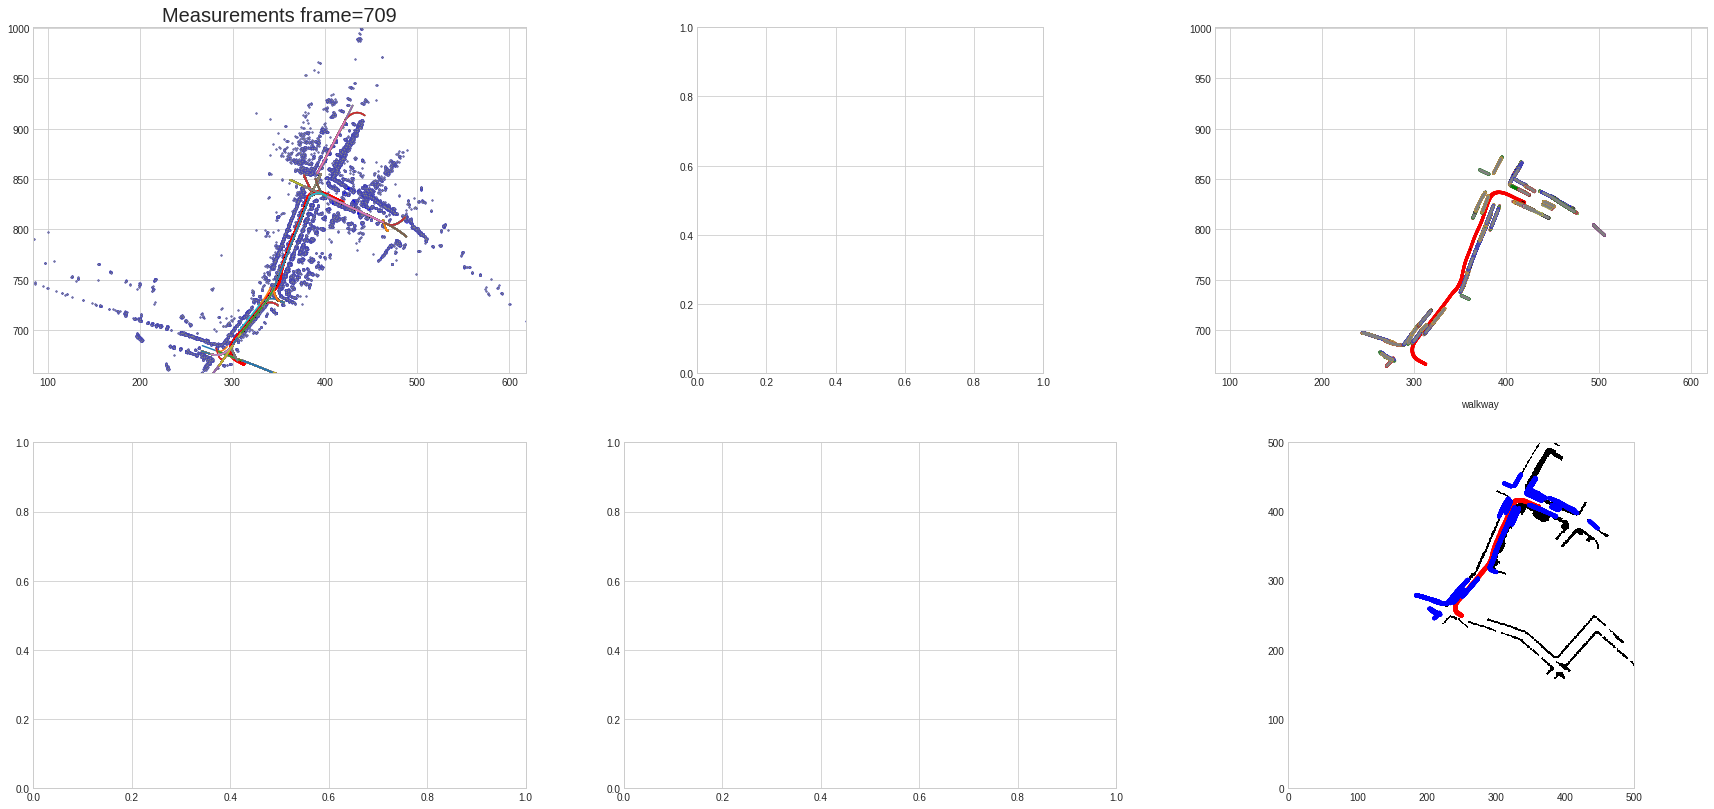

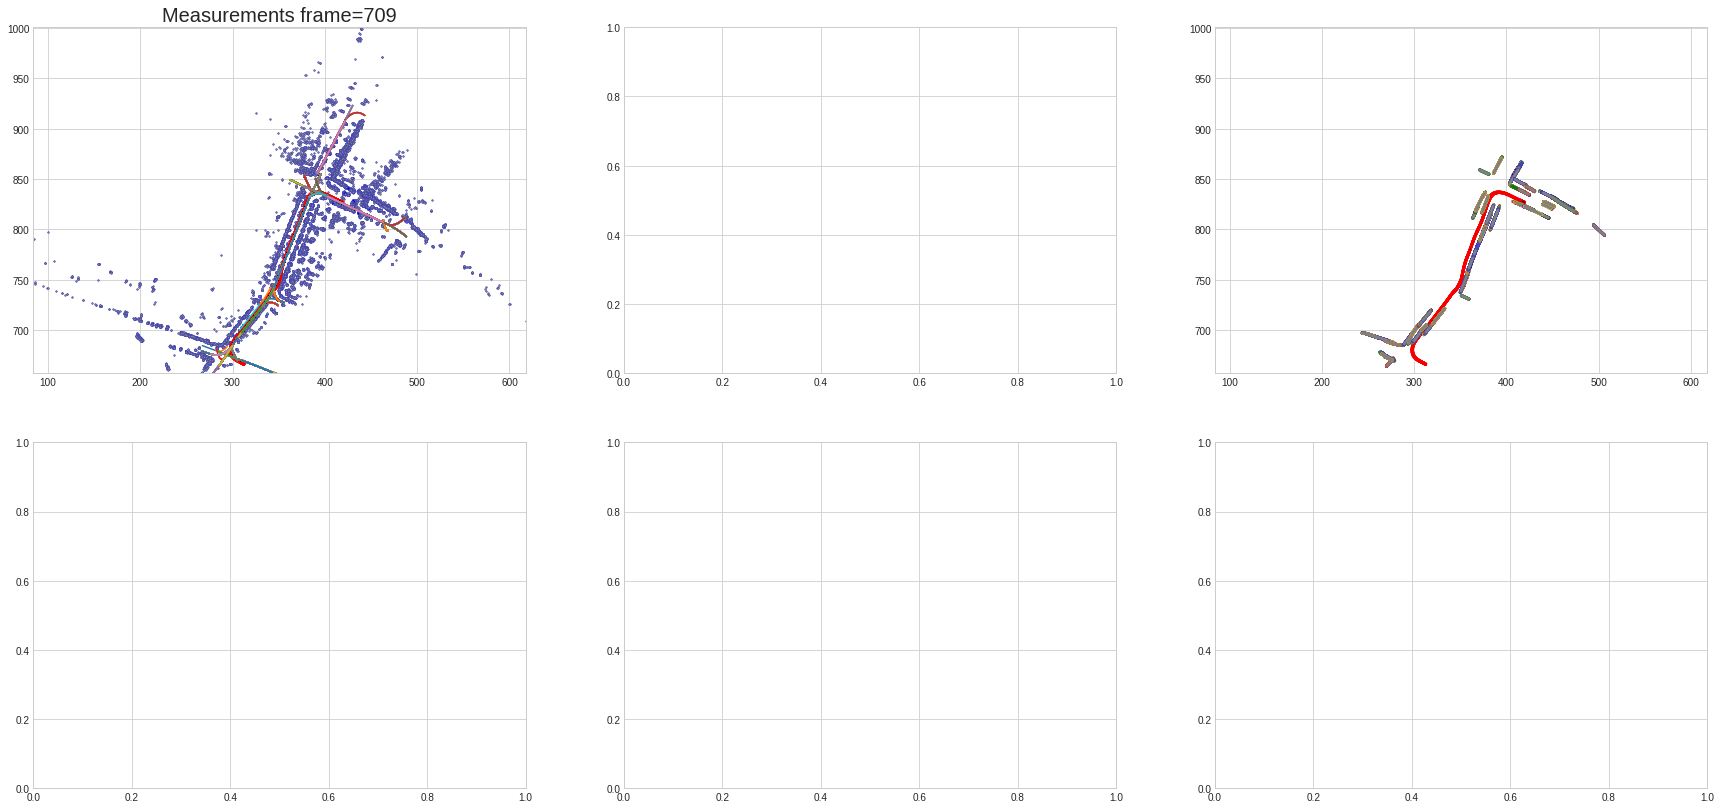

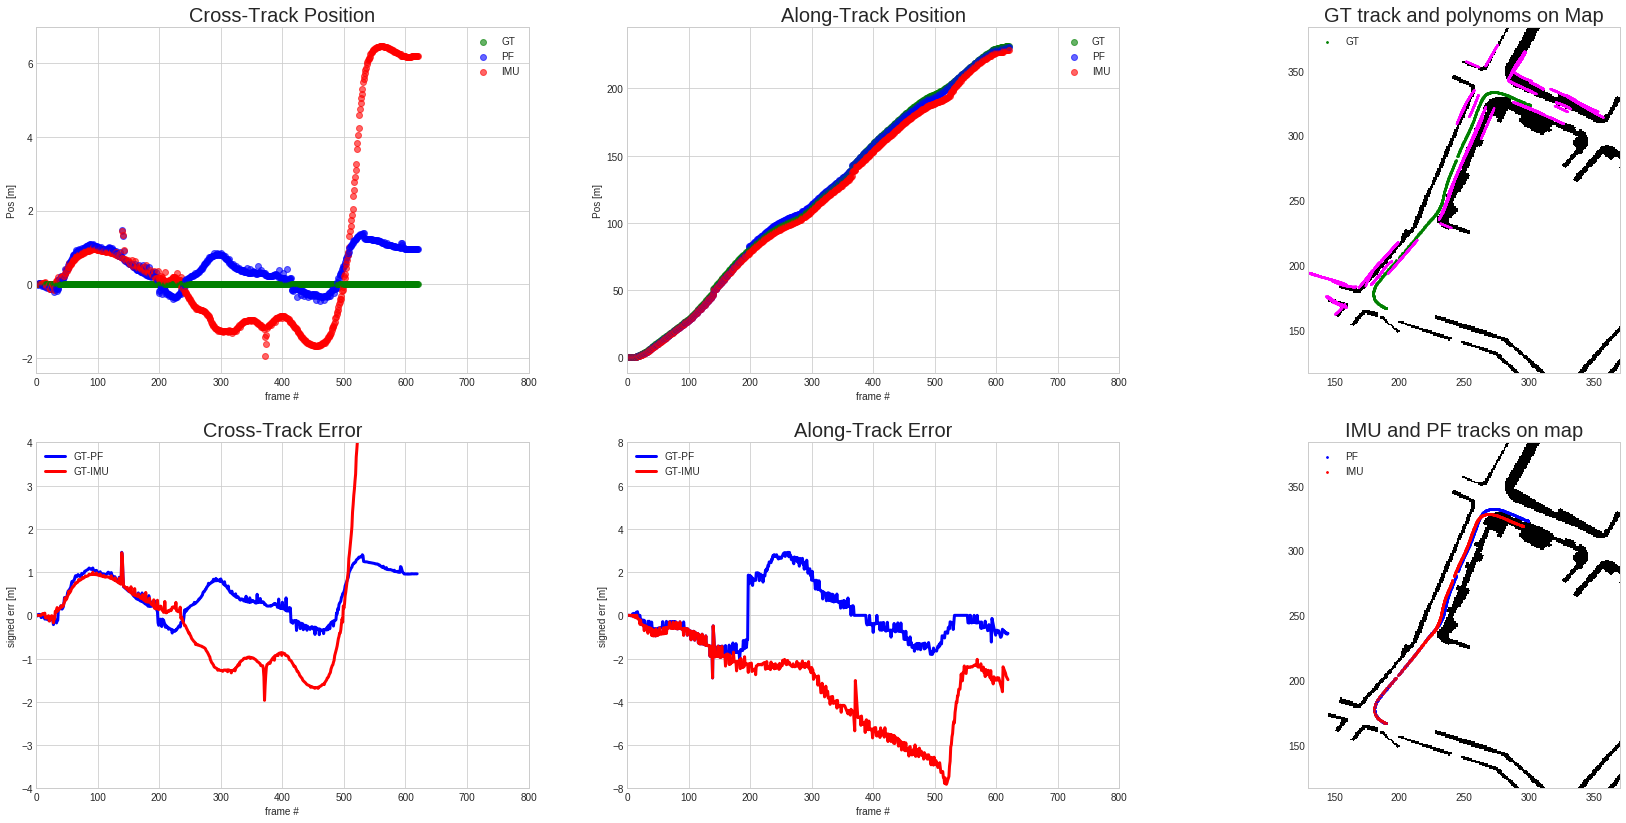

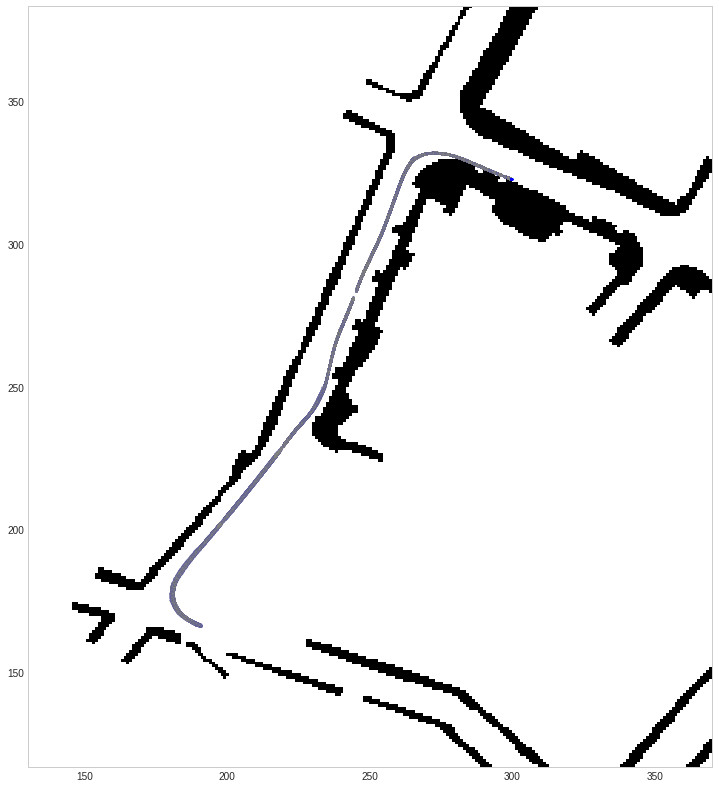

In [17]:
from tracker import Tracker
model = Tracker()
#sim = DynamicSimulation(model)
scene = 426
sim = NuscenesSimulation(model,scene_id=scene, mm=True, Nmax=800)
sim.run(start=90, N=620, generate_video=True, video_with_priors=True, debug=False)

In [10]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport
ridx 6 rot_imu.shape (15707, 2)
{'r1': 2.6628204014008063, 't': 0.0, 'r2': 2.6628204014008063, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 14 rot_imu.shape (15707, 2)
{'r1': 2.6627949733861525, 't': 3.6524852475105547e-06, 'r2': 2.6628356991819055, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 22 rot_imu.shape (15707, 2)
{'r1': 2.6628049800421434, 't': 7.044096037610249e-06, 'r2': 2.6628493090488834, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 29 rot_imu.shape (15707, 2)
{'r1': 2.6628207694639165, 't': 8.446427498841755e-06, 'r2': 2.6628268386988614, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 36 rot_imu.shape (15707, 2)
{'r1': 2.662837846370723, 't': 9.197416451494456e-06, 'r2': 2.662849392622197, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 43 rot_imu.shape (15707, 2)
{'r1': 2.662853890011002, 't': 1.0563597206372058e-05, 'r2': 2.

ridx 419 rot_imu.shape (15707, 2)
{'r1': 2.6628961864639202, 't': 8.074256331216348e-05, 'r2': 2.6633560096224014, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 427 rot_imu.shape (15707, 2)
{'r1': 2.662916529245141, 't': 8.24317692128742e-05, 'r2': 2.663371303436499, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 433 rot_imu.shape (15707, 2)
{'r1': 2.662917887445768, 't': 8.399211370483974e-05, 'r2': 2.6633699172530747, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 440 rot_imu.shape (15707, 2)
{'r1': 2.6629166347061353, 't': 8.557581252731409e-05, 'r2': 2.6633884450998355, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 447 rot_imu.shape (15707, 2)
{'r1': 2.662894564602469, 't': 8.644941193414898e-05, 'r2': 2.6634066357875907, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 461 rot_imu.shape (15707, 2)
{'r1': 2.662946791759234, 't': 8.987556899918162e-05, 'r2': 2.6634344613423417, 'trns': array([309.14

ridx 833 rot_imu.shape (15707, 2)
{'r1': 2.6613714233162833, 't': 0.00209417769272183, 'r2': 2.6608655986610685, 'trns': array([309.12646547, 668.78900083,   0.        ])}
ridx 841 rot_imu.shape (15707, 2)
{'r1': 2.660630807447412, 't': 0.008636977851915759, 'r2': 2.659795017421246, 'trns': array([309.10943907, 668.79788278,   0.        ])}
ridx 849 rot_imu.shape (15707, 2)
{'r1': 2.6595125399233783, 't': 0.0017655383575832884, 'r2': 2.6586509071484294, 'trns': array([309.07015979, 668.81843079,   0.        ])}
ridx 862 rot_imu.shape (15707, 2)
{'r1': 2.6571290546974087, 't': 0.025945949371885133, 'r2': 2.6567661637611137, 'trns': array([309.00138575, 668.85457498,   0.        ])}
ridx 870 rot_imu.shape (15707, 2)
{'r1': 2.655871473656139, 't': 0.03343143960674916, 'r2': 2.6553955522079957, 'trns': array([308.94935698, 668.88201009,   0.        ])}
ridx 878 rot_imu.shape (15707, 2)
{'r1': 2.6543800460149547, 't': 0.0293718500425261, 'r2': 2.6540489556973186, 'trns': array([308.87066781

ridx 1241 rot_imu.shape (15707, 2)
{'r1': 1.9390982334532973, 't': 0.975802709549498, 'r2': 1.9499758933307372, 'trns': array([300.59528256, 676.33513007,   0.        ])}
ridx 1249 rot_imu.shape (15707, 2)
{'r1': 1.9076521414178276, 't': 0.962455057709648, 'r2': 1.9171773343472418, 'trns': array([300.490731  , 676.62444065,   0.        ])}
ridx 1256 rot_imu.shape (15707, 2)
{'r1': 1.8785647058544674, 't': 0.9607352911495842, 'r2': 1.892432112367529, 'trns': array([300.40476985, 676.88211706,   0.        ])}
ridx 1271 rot_imu.shape (15707, 2)
{'r1': 1.816988575824767, 't': 0.9647818577310042, 'r2': 1.8247263649469887, 'trns': array([300.26294539, 677.42794604,   0.        ])}
ridx 1278 rot_imu.shape (15707, 2)
{'r1': 1.785711648255313, 't': 0.9603754389462181, 'r2': 1.797775208698825, 'trns': array([300.1974791 , 677.71104475,   0.        ])}
ridx 1286 rot_imu.shape (15707, 2)
{'r1': 1.754570185884225, 't': 0.9617059855177362, 'r2': 1.7667163271742665, 'trns': array([300.14192478, 677.9

ridx 1650 rot_imu.shape (15707, 2)
{'r1': 0.8943492247249403, 't': 1.1915107310320434, 'r2': 0.9034799609551475, 'trns': array([305.37407824, 690.86385303,   0.        ])}
ridx 1664 rot_imu.shape (15707, 2)
{'r1': 0.8913476193470807, 't': 1.1877164323240228, 'r2': 0.9010773889345115, 'trns': array([305.81529985, 691.41871135,   0.        ])}
ridx 1671 rot_imu.shape (15707, 2)
{'r1': 0.8892787427978852, 't': 1.2396055698577306, 'r2': 0.898782210029925, 'trns': array([306.02003918, 691.67491057,   0.        ])}
ridx 1679 rot_imu.shape (15707, 2)
{'r1': 0.8875642896818429, 't': 1.2667086237947434, 'r2': 0.8973760713976401, 'trns': array([306.22379134, 691.92910892,   0.        ])}
ridx 1686 rot_imu.shape (15707, 2)
{'r1': 0.8863010992927018, 't': 1.2583004064914944, 'r2': 0.896428262826012, 'trns': array([306.46857637, 692.23387524,   0.        ])}
ridx 1692 rot_imu.shape (15707, 2)
{'r1': 0.884725648282259, 't': 1.252715390384329, 'r2': 0.894885044908551, 'trns': array([306.69597568, 692

ridx 2052 rot_imu.shape (15707, 2)
{'r1': 0.8712136470245391, 't': 1.8045524099806332, 'r2': 0.8806280852756498, 'trns': array([321.99152838, 710.52110818,   0.        ])}
ridx 2065 rot_imu.shape (15707, 2)
{'r1': 0.8730454586945581, 't': 1.8860805017970512, 'r2': 0.8822539328939639, 'trns': array([322.56412385, 711.21272897,   0.        ])}
ridx 2073 rot_imu.shape (15707, 2)
{'r1': 0.8739419795452733, 't': 1.8682923233005544, 'r2': 0.8830933077655604, 'trns': array([322.88436951, 711.60018034,   0.        ])}
ridx 2080 rot_imu.shape (15707, 2)
{'r1': 0.8744546428390061, 't': 1.87552398477, 'r2': 0.8837024416562375, 'trns': array([323.16996036, 711.94615511,   0.        ])}
ridx 2088 rot_imu.shape (15707, 2)
{'r1': 0.8749941522196407, 't': 1.9134907207046545, 'r2': 0.8846049327259538, 'trns': array([323.4518407 , 712.28824259,   0.        ])}
ridx 2095 rot_imu.shape (15707, 2)
{'r1': 0.8756850911363121, 't': 1.885496375472974, 'r2': 0.8853762448408858, 'trns': array([323.77466138, 712.

ridx 2469 rot_imu.shape (15707, 2)
{'r1': 0.9093230138991226, 't': 2.3642527978082994, 'r2': 0.9145889776221413, 'trns': array([336.80471912, 728.99975621,   0.        ])}
ridx 2475 rot_imu.shape (15707, 2)
{'r1': 0.9089924587260875, 't': 2.353357820766603, 'r2': 0.9147650321503911, 'trns': array([337.05053671, 729.31780554,   0.        ])}
ridx 2483 rot_imu.shape (15707, 2)
{'r1': 0.9099782138274056, 't': 2.3462633148045553, 'r2': 0.9159297501764101, 'trns': array([337.26003282, 729.58963766,   0.        ])}
ridx 2491 rot_imu.shape (15707, 2)
{'r1': 0.9117673386359729, 't': 2.3819930280902413, 'r2': 0.9167552257805381, 'trns': array([337.47474274, 729.868794  ,   0.        ])}
ridx 2498 rot_imu.shape (15707, 2)
{'r1': 0.9124246682688582, 't': 2.4002395886541477, 'r2': 0.9161971109399115, 'trns': array([337.67711704, 730.13162524,   0.        ])}
ridx 2504 rot_imu.shape (15707, 2)
{'r1': 0.9107275998186707, 't': 2.4155207169054687, 'r2': 0.9154342285091376, 'trns': array([337.90609179,

ridx 2876 rot_imu.shape (15707, 2)
{'r1': 1.0304673363386814, 't': 2.359490188687721, 'r2': 1.0267385788057692, 'trns': array([347.27414363, 741.96968942,   0.        ])}
ridx 2883 rot_imu.shape (15707, 2)
{'r1': 1.0391304534849355, 't': 2.3813910066767483, 'r2': 1.0360618186451698, 'trns': array([347.37392153, 742.13789243,   0.        ])}
ridx 2891 rot_imu.shape (15707, 2)
{'r1': 1.0465524784930544, 't': 2.3908395715577915, 'r2': 1.0452937342863984, 'trns': array([347.47200902, 742.30679092,   0.        ])}
ridx 2898 rot_imu.shape (15707, 2)
{'r1': 1.054924259212062, 't': 2.3838767514231596, 'r2': 1.051962898296468, 'trns': array([347.58027754, 742.49611408,   0.        ])}
ridx 2913 rot_imu.shape (15707, 2)
{'r1': 1.0705309957118339, 't': 2.3696705933875397, 'r2': 1.069710722762071, 'trns': array([347.7676583, 742.8377261,   0.       ])}
ridx 2920 rot_imu.shape (15707, 2)
{'r1': 1.079425896466807, 't': 2.346650077148821, 'r2': 1.0770599784360724, 'trns': array([347.86170759, 743.012

ridx 3291 rot_imu.shape (15707, 2)
{'r1': 1.3616605298105602, 't': 2.690706532770763, 'r2': 1.3524105989661968, 'trns': array([351.33309956, 752.61472174,   0.        ])}
ridx 3306 rot_imu.shape (15707, 2)
{'r1': 1.362517026406457, 't': 2.689474889909159, 'r2': 1.353448634672505, 'trns': array([351.46717762, 753.22153517,   0.        ])}
ridx 3312 rot_imu.shape (15707, 2)
{'r1': 1.3624114047138811, 't': 2.705945717717085, 'r2': 1.3539430671670547, 'trns': array([351.53047162, 753.50867018,   0.        ])}
ridx 3321 rot_imu.shape (15707, 2)
{'r1': 1.36264927620297, 't': 2.7511070903939623, 'r2': 1.354823214018141, 'trns': array([351.59235554, 753.79059877,   0.        ])}
ridx 3335 rot_imu.shape (15707, 2)
{'r1': 1.3621847644745022, 't': 2.757639662031983, 'r2': 1.3545292130094089, 'trns': array([351.73695353, 754.44842204,   0.        ])}
ridx 3350 rot_imu.shape (15707, 2)
{'r1': 1.3608607708085168, 't': 2.8006557399658134, 'r2': 1.3540071316493283, 'trns': array([351.87894975, 755.092

ridx 3714 rot_imu.shape (15707, 2)
{'r1': 1.1653006854437409, 't': 4.247994916550364, 'r2': 1.1720495826184163, 'trns': array([356.88082744, 771.08990337,   0.        ])}
ridx 3728 rot_imu.shape (15707, 2)
{'r1': 1.1650983718893286, 't': 4.276498528751796, 'r2': 1.1712971182823064, 'trns': array([357.12286082, 771.66220349,   0.        ])}
ridx 3735 rot_imu.shape (15707, 2)
{'r1': 1.165328541405959, 't': 4.272245737758991, 'r2': 1.171423451600304, 'trns': array([357.23855225, 771.93585037,   0.        ])}
ridx 3743 rot_imu.shape (15707, 2)
{'r1': 1.1660361539687147, 't': 4.290817903561436, 'r2': 1.1716054416151391, 'trns': array([357.35245125, 772.20539343,   0.        ])}
ridx 3750 rot_imu.shape (15707, 2)
{'r1': 1.166732389658973, 't': 4.287853208803776, 'r2': 1.172285767626255, 'trns': array([357.47888473, 772.50515342,   0.        ])}
ridx 3757 rot_imu.shape (15707, 2)
{'r1': 1.1680250414815019, 't': 4.298823876371992, 'r2': 1.1733986273358286, 'trns': array([357.59277186, 772.7760

ridx 4149 rot_imu.shape (15707, 2)
{'r1': 1.1168038198808237, 't': 5.2687986556156154, 'r2': 1.124895327783943, 'trns': array([366.22170353, 793.55558761,   0.        ])}
ridx 4157 rot_imu.shape (15707, 2)
{'r1': 1.115447256466627, 't': 5.254240820800205, 'r2': 1.1236100133162465, 'trns': array([366.4050292 , 793.93678809,   0.        ])}
ridx 4170 rot_imu.shape (15707, 2)
{'r1': 1.1123307843250292, 't': 5.243259895741583, 'r2': 1.1216977923627807, 'trns': array([366.74996005, 794.65050134,   0.        ])}
ridx 4179 rot_imu.shape (15707, 2)
{'r1': 1.1121184858156354, 't': 5.259098494692827, 'r2': 1.1212505359963385, 'trns': array([366.92198805, 795.00603516,   0.        ])}
ridx 4186 rot_imu.shape (15707, 2)
{'r1': 1.1120561712095078, 't': 5.29891409211095, 'r2': 1.1212919006364457, 'trns': array([367.09202448, 795.3575353 ,   0.        ])}
ridx 4194 rot_imu.shape (15707, 2)
{'r1': 1.112539277696289, 't': 5.35970025078735, 'r2': 1.1216360434293264, 'trns': array([367.25514255, 795.6950

ridx 4577 rot_imu.shape (15707, 2)
{'r1': 1.2170151794186108, 't': 6.074327563023025, 'r2': 1.2255680519906171, 'trns': array([374.26424176, 812.69710609,   0.        ])}
ridx 4585 rot_imu.shape (15707, 2)
{'r1': 1.2170920477421174, 't': 6.094265667516001, 'r2': 1.2256985555165512, 'trns': array([374.38006185, 813.01901149,   0.        ])}
ridx 4600 rot_imu.shape (15707, 2)
{'r1': 1.2173346975347545, 't': 6.099475019409003, 'r2': 1.225932506267874, 'trns': array([374.62919806, 813.71195345,   0.        ])}
ridx 4607 rot_imu.shape (15707, 2)
{'r1': 1.2173998279689475, 't': 6.103915795454759, 'r2': 1.2260352484349188, 'trns': array([374.74713333, 814.04007218,   0.        ])}
ridx 4615 rot_imu.shape (15707, 2)
{'r1': 1.2180885883211876, 't': 6.149203346287801, 'r2': 1.226098090883577, 'trns': array([374.86603297, 814.37092544,   0.        ])}
ridx 4622 rot_imu.shape (15707, 2)
{'r1': 1.2178594501033293, 't': 6.196970899061926, 'r2': 1.2260094487156497, 'trns': array([374.97657516, 814.67

ridx 5015 rot_imu.shape (15707, 2)
{'r1': 0.7853590819152114, 't': 6.714551308692715, 'r2': 0.7947635365020483, 'trns': array([381.3131853 , 827.80740056,   0.        ])}
ridx 5022 rot_imu.shape (15707, 2)
{'r1': 0.7638627872608971, 't': 6.697882394346152, 'r2': 0.7762082258908721, 'trns': array([381.45590924, 827.94705912,   0.        ])}
ridx 5029 rot_imu.shape (15707, 2)
{'r1': 0.7427225285151817, 't': 6.712569443548328, 'r2': 0.7588815536114683, 'trns': array([381.57161116, 828.05643684,   0.        ])}
ridx 5036 rot_imu.shape (15707, 2)
{'r1': 0.7216514737364695, 't': 6.733717648562671, 'r2': 0.7359683776337123, 'trns': array([381.68404997, 828.15798431,   0.        ])}
ridx 5051 rot_imu.shape (15707, 2)
{'r1': 0.6804013021094152, 't': 6.711336267642047, 'r2': 0.6897757307511216, 'trns': array([381.94348858, 828.3714608 ,   0.        ])}
ridx 5057 rot_imu.shape (15707, 2)
{'r1': 0.659355643761868, 't': 6.7077870487399265, 'r2': 0.6736045136783543, 'trns': array([382.06264626, 828.

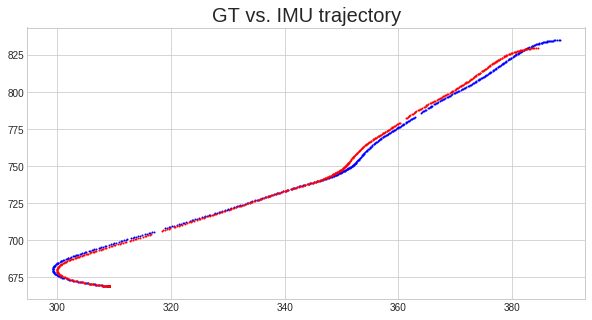

In [9]:
scene = 426
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 600
gt = np.zeros((N, 2))
imu = np.zeros((N, 2))
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu[t, :] = trns1[0:2]
    odom = dataset.getOdometry()
    print(odom)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title("GT vs. IMU trajectory", fontsize=20)
ax.scatter(gt[:, 0],gt[:, 1],color='blue',s=1)
ax.scatter(imu[:, 0],imu[:, 1],color='red',s=1)

In [32]:
import numpy as np
from scipy.spatial.distance import cdist

mat = np.eye(10)
val = np.argwhere(mat > 0)
dists = cdist([(4,0)], val)
print(np.argmin(dists), val[2])
#data = np.random.uniform(0., 1., (1000, 2))

2 [2 2]


In [4]:
from pyquaternion import Quaternion

Quaternion.Inverse()

AttributeError: type object 'Quaternion' has no attribute 'Inverse'

In [351]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport
ridx 6024 rot_imu.shape (15707, 2)


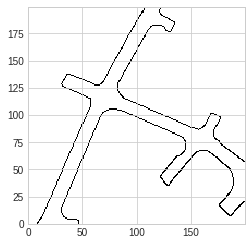

In [379]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')